In [155]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import lightgbm as lgb
from sklearn.preprocessing import RobustScaler
import logging
import matplotlib.pyplot as plt


In [157]:
# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %I:%M:%S %p %Z'
)
logging.info("Revised LightGBM Model Script started at 03:50 PM IST on Thursday, June 12, 2025")

# Paths
metadata_path = r"D:\NASA_Battery_Dataset\cleaned_dataset\metadata.csv"
data_folder = r"D:\NASA_Battery_Dataset\cleaned_dataset\data"


2025-06-12 03:47:26 PM India Standard Time - INFO - Revised LightGBM Model Script started at 03:50 PM IST on Thursday, June 12, 2025


In [159]:
# Load metadata
try:
    metadata = pd.read_csv(metadata_path)
except FileNotFoundError:
    logging.error(f"Metadata file not found at {metadata_path}")
    raise

# Inspect metadata before filtering
logging.info(f"Total rows in metadata: {len(metadata)}")
logging.info(f"Battery IDs in metadata: {metadata['battery_id'].unique()}")

# Filter for B0005 only and add cycle_index
metadata_filtered = metadata[metadata['battery_id'] == 'B0005'].copy()
metadata_filtered['cycle_index'] = range(len(metadata_filtered))
logging.info(f"Filtered for B0005. Shape: {metadata_filtered.shape}")
logging.info(f"Expected ~168 cycles for B0005. Actual cycles: {len(metadata_filtered)}")
logging.info(f"Battery IDs after filtering: {metadata_filtered['battery_id'].unique()}")


2025-06-12 03:47:50 PM India Standard Time - INFO - Total rows in metadata: 7565
2025-06-12 03:47:50 PM India Standard Time - INFO - Battery IDs in metadata: ['B0047' 'B0045' 'B0048' 'B0046' 'B0043' 'B0032' 'B0039' 'B0040' 'B0029'
 'B0028' 'B0042' 'B0034' 'B0038' 'B0033' 'B0030' 'B0041' 'B0027' 'B0044'
 'B0036' 'B0025' 'B0026' 'B0031' 'B0049' 'B0050' 'B0052' 'B0051' 'B0006'
 'B0005' 'B0007' 'B0018' 'B0053' 'B0054' 'B0056' 'B0055']
2025-06-12 03:47:50 PM India Standard Time - INFO - Filtered for B0005. Shape: (616, 11)
2025-06-12 03:47:50 PM India Standard Time - INFO - Expected ~168 cycles for B0005. Actual cycles: 616
2025-06-12 03:47:50 PM India Standard Time - INFO - Battery IDs after filtering: ['B0005']


In [161]:
# If the number of cycles is incorrect, raise an error
if len(metadata_filtered) > 200:  # Allow some tolerance above 168
    logging.error("Unexpected number of cycles for B0005. Check the dataset for duplicates or incorrect filtering.")
    raise ValueError("Dataset for B0005 has too many cycles. Expected ~168, got {}".format(len(metadata_filtered)))

# Function to parse complex numbers and extract Re (real part)
def parse_complex_to_re(value):
    try:
        if isinstance(value, complex):
            return value.real
        if isinstance(value, str):
            value = value.strip('()')
            if 'j' in value:
                if 'e' in value:
                    parts = value.split('j')
                    real_part = float(parts[0].split('-')[0]) if '-' in parts[0] else float(parts[0])
                    return real_part
                else:
                    if '+' in value:
                        real, imag = value.split('+')
                    else:
                        parts = value.split('-')
                        real = parts[0] if parts[0] else '0'
                        imag = '-' + parts[1] if len(parts) > 1 else '0'
                        if len(parts) == 3:
                            real = '-' + parts[1]
                            imag = '-' + parts[2]
                    real = float(real) if real else 0.0
                    return real
        return float(value)
    except (ValueError, TypeError) as e:
        logging.warning(f"Could not parse complex value {value}: {str(e)}")
        return np.nan


2025-06-12 03:49:47 PM India Standard Time - ERROR - Unexpected number of cycles for B0005. Check the dataset for duplicates or incorrect filtering.


ValueError: Dataset for B0005 has too many cycles. Expected ~168, got 616

In [137]:
# Extract features from charge/discharge cycles
def extract_features_charge_discharge(filepath, re_value, cycle_type, cycle_index, battery_id):
    try:
        df = pd.read_csv(filepath)
        features = {
            'avg_current': df['Current_measured'].mean(),
            'avg_voltage': df['Voltage_measured'].mean(),
            'avg_temperature': df['Temperature_measured'].mean(),
            'cycle_index': cycle_index,
            'cycle_type': cycle_type,
            'battery_id': battery_id,
            'Re': re_value
        }
        return features
    except Exception as e:
        logging.error(f"Error processing charge/discharge file {filepath}: {str(e)}")
        return None


In [139]:
# Extract features from impedance cycles
def extract_features_impedance(filepath, re_value, cycle_type, cycle_index, battery_id):
    try:
        df = pd.read_csv(filepath)
        if 'Battery_impedance' not in df.columns:
            logging.warning(f"Battery_impedance column missing in {filepath}")
            return None
        impedance_value = df['Battery_impedance'].iloc[0]
        avg_impedance = parse_complex_to_re(impedance_value)
        features = {
            'avg_impedance': avg_impedance,
            'cycle_index': cycle_index,
            'cycle_type': cycle_type,
            'battery_id': battery_id,
            'Re': re_value
        }
        return features
    except Exception as e:
        logging.error(f"Error processing impedance file {filepath}: {str(e)}")
        return None


In [141]:
# Propagate Re values using data from data_folder
re_values = []
current_re = 0.073589  # Initial Re value
for idx, row in metadata_filtered.iterrows():
    if row['type'] == 'impedance':
        filepath = os.path.join(data_folder, row['filename'])
        if os.path.exists(filepath):
            df = pd.read_csv(filepath)
            if 'Battery_impedance' in df.columns:
                impedance_value = df['Battery_impedance'].iloc[0]
                re_value = parse_complex_to_re(impedance_value)
                current_re = re_value if not pd.isna(re_value) else current_re
            else:
                logging.warning(f"Battery_impedance column missing in {filepath}")
        else:
            logging.warning(f"File not found: {filepath}")
    re_values.append(current_re)

metadata_filtered['Re'] = re_values
logging.info(f"Rows with valid Re: {metadata_filtered['Re'].notna().sum()}")


2025-06-12 03:37:47 PM India Standard Time - INFO - Rows with valid Re: 616


In [143]:
# Check for NaNs in Re
if metadata_filtered['Re'].isna().sum() > 0:
    logging.warning("NaNs found in Re. Filling with initial Re value...")
    metadata_filtered['Re'] = metadata_filtered['Re'].fillna(current_re)
    logging.info(f"NaNs in Re after filling: {metadata_filtered['Re'].isna().sum()}")

# Extract features for each file
features_list = []
processed_files = []
skipped_files = []

for idx, row in metadata_filtered.iterrows():
    csv_name = row['filename']
    cycle_type = row['type']
    full_path = os.path.join(data_folder, csv_name)
    re_value = row['Re']
    cycle_index = row['cycle_index']
    battery_id = row['battery_id']

    if not os.path.exists(full_path):
        logging.warning(f"File not found: {full_path}")
        skipped_files.append(csv_name)
        continue

    if cycle_type in ['charge', 'discharge']:
        features = extract_features_charge_discharge(full_path, re_value, cycle_type, cycle_index, battery_id)
    else:  # impedance
        features = extract_features_impedance(full_path, re_value, cycle_type, cycle_index, battery_id)

    if features:
        features_list.append(features)
        processed_files.append(csv_name)
    else:
        skipped_files.append(csv_name)

logging.info(f"Processed {len(processed_files)} files successfully")
logging.info(f"Skipped {len(skipped_files)} files: {skipped_files}")


2025-06-12 03:38:35 PM India Standard Time - INFO - Processed 616 files successfully
2025-06-12 03:38:35 PM India Standard Time - INFO - Skipped 0 files: []


In [145]:
# Create DataFrame from features
features_df = pd.DataFrame(features_list)
logging.info(f"Features DataFrame shape: {features_df.shape}")

# Handle missing values
features_df.fillna({'avg_current': 0, 'avg_voltage': 0, 'avg_temperature': 0, 'avg_impedance': 0}, inplace=True)

# Feature engineering: Add temporal features
features_df['Re_diff'] = features_df['Re'].diff().fillna(0)
features_df['Re_moving_avg'] = features_df['Re'].rolling(window=5, min_periods=1).mean()
features_df['impedance_count'] = features_df['cycle_type'].apply(lambda x: 1 if x == 'impedance' else 0).cumsum()

# Encode categorical variables
features_df['cycle_type_encoded'] = features_df['cycle_type'].map({'charge': 0, 'discharge': 1, 'impedance': 2})


2025-06-12 03:38:54 PM India Standard Time - INFO - Features DataFrame shape: (616, 8)


In [147]:
# Prepare features and target
X = features_df.drop(columns=['Re', 'cycle_type', 'battery_id'])
y = features_df['Re']

# Chronological split (80% train, 20% test)
train_size = int(0.8 * len(X))
X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

# Scale features
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to LightGBM dataset
train_data = lgb.Dataset(X_train_scaled, label=y_train)
test_data = lgb.Dataset(X_test_scaled, label=y_test, reference=train_data)


In [149]:
# Define LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# Train the model
lgb_model = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    valid_sets=[train_data, test_data],
    callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=False)]
)


In [151]:
# Predict on test set
y_pred = lgb_model.predict(X_test_scaled)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"✅ LightGBM Model Evaluation on Test Set (B0005):")
print(f"RMSE = {rmse:.5f}")
print(f"R²   = {r2:.5f}")
print(f"MAE  = {mae:.5f}")
print(f"MSE  = {mse:.5f}")


✅ LightGBM Model Evaluation on Test Set (B0005):
RMSE = 0.00425
R²   = -0.47446
MAE  = 0.00365
MSE  = 0.00002


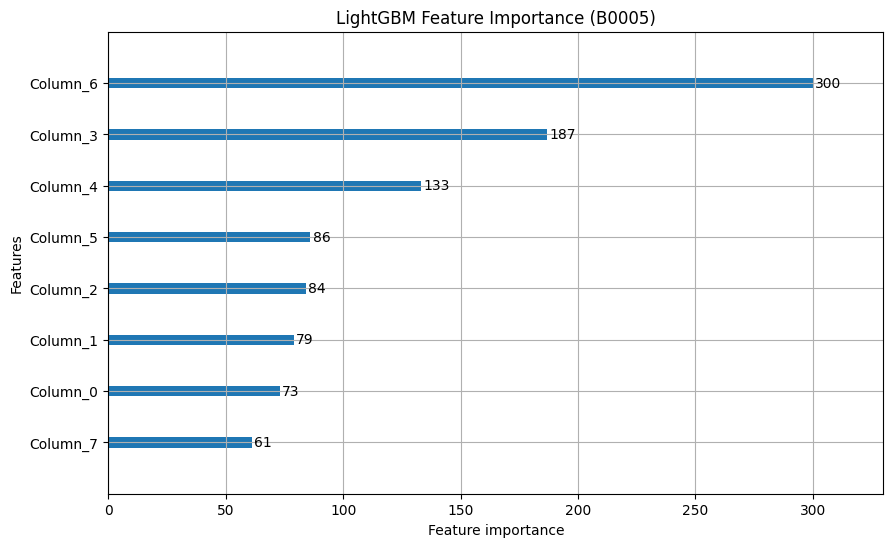

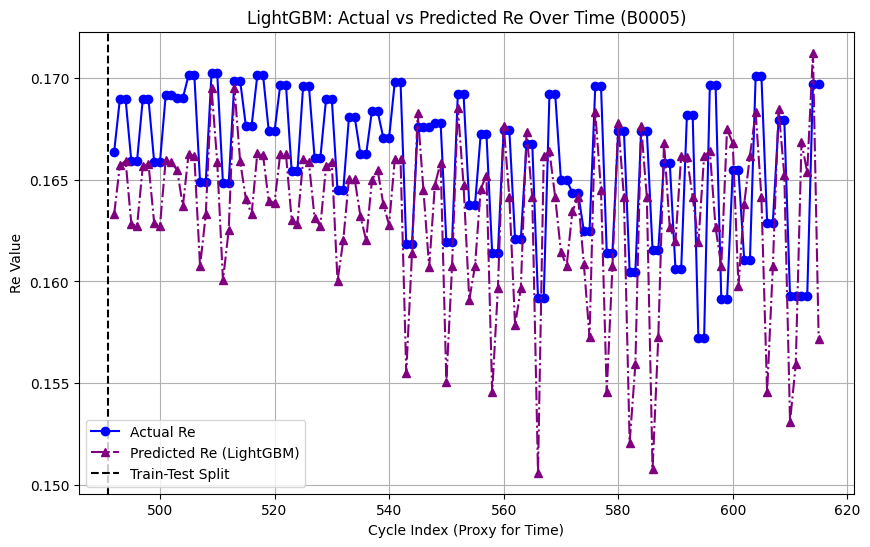

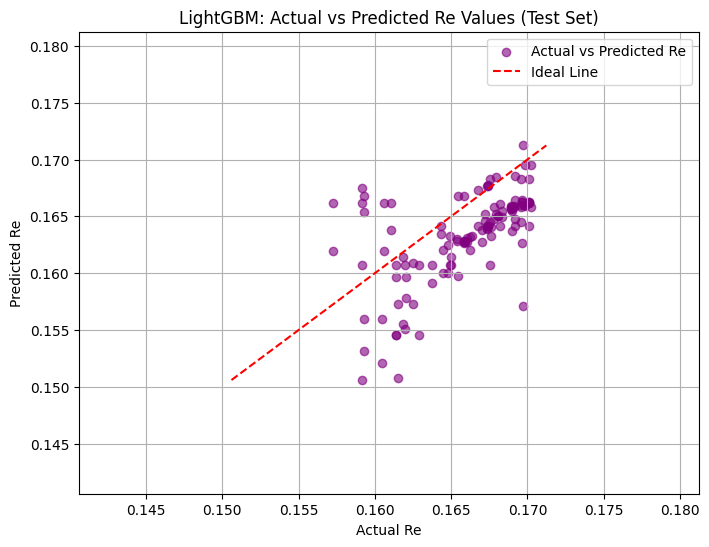

In [153]:
# Feature importance plot
lgb.plot_importance(lgb_model, max_num_features=10, figsize=(10, 6))
plt.title('LightGBM Feature Importance (B0005)')
plt.show()

# Plot actual vs predicted over time
plt.figure(figsize=(10, 6))
plt.plot(X_test['cycle_index'], y_test, marker='o', linestyle='-', color='blue', label='Actual Re')
plt.plot(X_test['cycle_index'], y_pred, marker='^', linestyle='-.', color='purple', label='Predicted Re (LightGBM)')
plt.axvline(x=X_train['cycle_index'].iloc[-1], color='black', linestyle='--', label='Train-Test Split')
plt.xlabel('Cycle Index (Proxy for Time)')
plt.ylabel('Re Value')
plt.title('LightGBM: Actual vs Predicted Re Over Time (B0005)')
plt.grid(True)
plt.legend()
plt.show()

# Scatter plot: Actual vs Predicted Re
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='purple', alpha=0.6, label='Actual vs Predicted Re')
min_val = min(np.min(y_test), np.min(y_pred))
max_val = max(np.max(y_test), np.max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal Line')
plt.xlabel('Actual Re')
plt.ylabel('Predicted Re')
plt.title('LightGBM: Actual vs Predicted Re Values (Test Set)')
plt.legend()
plt.grid(True)
plt.xlim(min_val - 0.01, max_val + 0.01)
plt.ylim(min_val - 0.01, max_val + 0.01)
plt.show()